# **FOOD-101 : Processing segnali bidimensionali**


- 101 classes
- for each type of food 750 training samples, 250 test samples.

We have sampled the dataset considering only **50 classes** randomly choosen due to computational limits.

In [1]:
import pandas as pd
import random
# Keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization, Dropout, Dense
from keras.optimizers import Adam

# KDTree creation and saving
from sklearn.neighbors import KDTree
import joblib

# Image management
from skimage import io # Input/output
from skimage import transform # Geometric transformations (e.g. resize)
from skimage import filters # Local processing
from skimage import color # Change of color space

import pickle
from pathlib import Path
from scipy.linalg import fractional_matrix_power
import scipy.misc
import cv2
import os.path
import glob
import argparse
import seaborn as sns
from google.colab import drive
from zipfile import ZipFile
from time import time
from shutil import copyfile
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load data and Explore them

In [4]:
#based on the account used
archive = ZipFile('/content/gdrive/MyDrive/Second year/DSIM_project/food-50.zip', 'r')
#archive = ZipFile('/content/gdrive/MyDrive/DSIM_project/food-50.zip', 'r')
archive.extractall()
archive.close()

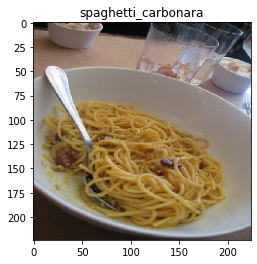

In [ ]:
img = kimage.load_img('/content/food-50/spaghetti_carbonara/10053.jpg', target_size=(224, 224))

plt.imshow(img)
plt.title('spaghetti_carbonara')
plt.show()

In [5]:
image_dir = Path('/content/food-50')

extract labels from paths

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

In [ ]:
images.head()

Filepath  Label
0  /content/food-50/tacos/1188062.jpg  tacos
1   /content/food-50/tacos/560529.jpg  tacos
2   /content/food-50/tacos/815394.jpg  tacos
3  /content/food-50/tacos/1059239.jpg  tacos
4  /content/food-50/tacos/2197933.jpg  tacos

Show one random image from each class

In [ ]:
subplot = pd.DataFrame()

paths=[]
labels= []

for i in range(len(images)):
  name = images.iloc[i]['Label']
  if name not in labels:
    paths.append(images.iloc[i]['Filepath'])
    labels.append(name)

subplot['paths'] = paths
subplot['labels'] = labels

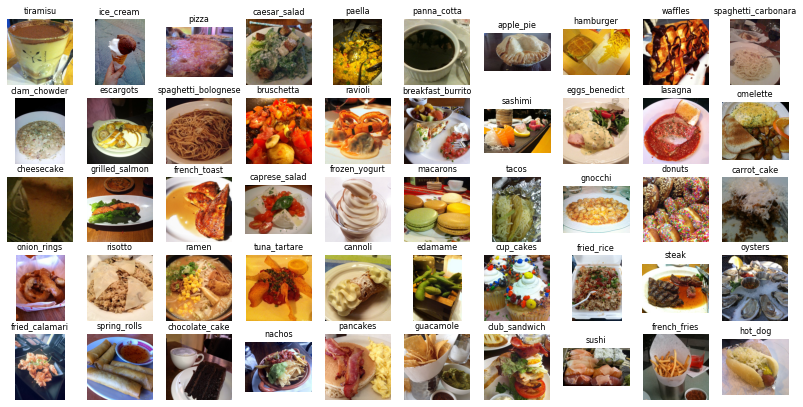

In [ ]:
#one image for each class

plt.figure(figsize=(14,7))
for i in range(50):
  plt.subplot(5, 10, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = io.imread(subplot.iloc[i]['paths'])
  plt.imshow(image)
  plt.title(subplot.iloc[i]['labels'], fontsize=8)
plt.show()

Now let's split the dataset into train and test sets using 70% of data for the training set

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1, stratify= images['Label'])

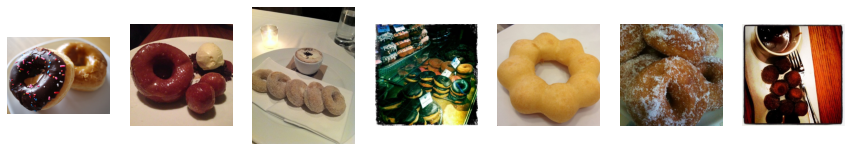

In [ ]:
plt.figure(figsize=(15,3))
for i,path in enumerate(train_df[train_df.Label == 'donuts']['Filepath'][0:7]):
  plt.subplot(1,7, 1+i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  image = io.imread(path)
  plt.imshow(image)

plt.show()

We can notice that:
- in general images connected to the same category are in any case very different from each other in terms of perspective, number of elements in the photo, framing;
- there are wrong images.

## **Sample with 5 classes**

In [ ]:
#random.seed(3)
# get 5 random elements
#result = random.sample(labels, 5)
result = ['oysters', 'lasagna', 'paella', 'sushi', 'risotto']

In [ ]:
train_mini = train_df.loc[images['Filepath'].apply(lambda x: True if any(elem in x for elem in result) else False)]
test_mini = test_df.loc[images['Filepath'].apply(lambda x: True if any(elem in x for elem in result) else False)]

In [ ]:
#set parameters
num_classes = 5
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)


#rescale 1./255 from [0,255] to [0,1]
train_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



train_images = train_generator.flow_from_dataframe(
    dataframe=train_mini,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_mini,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_mini,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 2800 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.
Found 1500 validated image filenames belonging to 5 classes.


### Net from scratch

In [ ]:
# Architecture definition (v1)
inputs = keras.Input((224,224,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 75, 75, 64)        0         
                                                             

In [ ]:
net.compile(optimizer = Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Model training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = net.fit(train_images,
          epochs=30,
          validation_data=val_images,
          callbacks = [callback],
          verbose = 1);

Epoch 1/30
44/44 [==============================] - 202s 5s/step - loss: 0.9162 - accuracy: 0.6632 - val_loss: 1.0439 - val_accuracy: 0.6071
Epoch 2/30
44/44 [==============================] - 201s 5s/step - loss: 0.9111 - accuracy: 0.6757 - val_loss: 1.1041 - val_accuracy: 0.5443
Epoch 3/30
44/44 [==============================] - 193s 4s/step - loss: 0.8938 - accuracy: 0.6839 - val_loss: 1.0617 - val_accuracy: 0.5814
Epoch 4/30
44/44 [==============================] - 192s 4s/step - loss: 0.8656 - accuracy: 0.6911 - val_loss: 1.0239 - val_accuracy: 0.6057
Epoch 5/30
44/44 [==============================] - 195s 4s/step - loss: 0.8694 - accuracy: 0.6857 - val_loss: 1.0877 - val_accuracy: 0.5929
Epoch 6/30
44/44 [==============================] - 196s 4s/step - loss: 0.8441 - accuracy: 0.7021 - val_loss: 1.0157 - val_accuracy: 0.6043
Epoch 7/30
44/44 [==============================] - 194s 4s/step - loss: 0.8198 - accuracy: 0.7107 - val_loss: 1.0084 - val_accuracy: 0.6243
Epoch 8/30
44

Text(0.5, 0.98, 'Net from scratch - 5 classes')

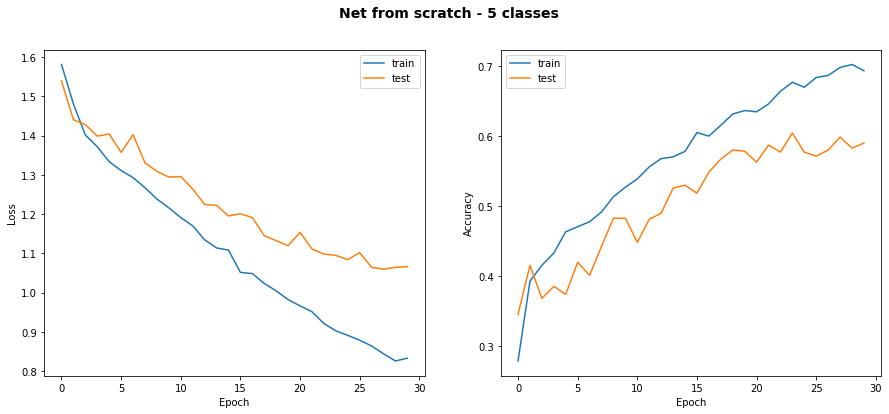

In [ ]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.suptitle("Net from scratch - 5 classes", fontsize=14, fontweight='bold')

In [ ]:
#net.save('from_scratch_5.h5')
net = None
net_1 = keras.models.load_model('from_scratch_5.h5')

In [ ]:
class_probs = net.predict(test_images)

top1 = 0.0

for i, l in enumerate(test_images.labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:3]
    if top_values[0] == l:
        top1 += 1.0

print("top1 acc", top1/len(test_images.labels))

24/24 [==============================] - 9s 329ms/step
top1 acc 0.606


In [ ]:
#classification report

predictions = np.argmax(class_probs, axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

     lasagna       0.64      0.62      0.63       300
     oysters       0.54      0.79      0.64       300
      paella       0.70      0.56      0.62       300
     risotto       0.65      0.47      0.54       300
       sushi       0.57      0.59      0.58       300

    accuracy                           0.61      1500
   macro avg       0.62      0.61      0.60      1500
weighted avg       0.62      0.61      0.60      1500



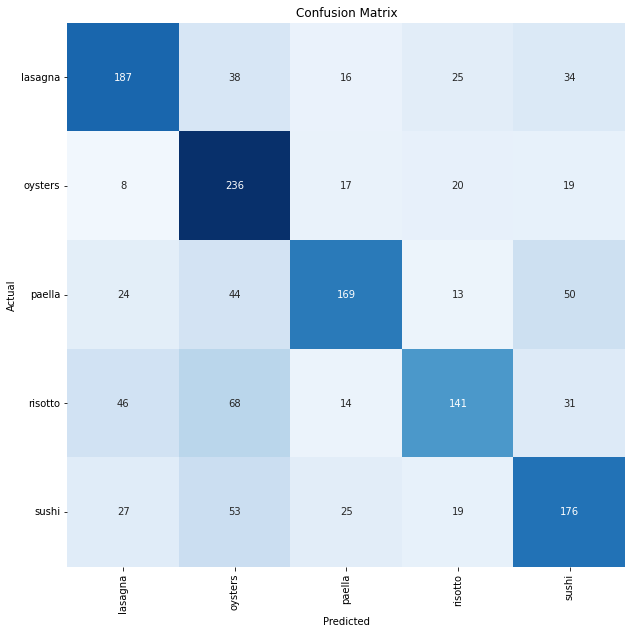

In [ ]:
#confusion matrix

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(5) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(5) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Enhance net

- Little Augmentation 
    - horizontal and vertical flip : aumentare la diversità delle immagini di addestramento e migliorare la capacità della rete neurale di generalizzare a nuove immagini; 
    - random contrast : operazione di contrasto casuale alle immagini in input;
- More conv2D, pooling (more complexity, better results)
- 	Batch normalization layers (more stability, prevent saturation activations)
-	Dropout (prevent overfitting)


In [ ]:
inputs = keras.Input((224,224,3))

x = inputs

#augmentation
x = keras.layers.RandomFlip()(x) #horizontal_and_vertical
x = keras.layers.RandomContrast(0.25)(x)

x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)

x = keras.layers.Conv2D(64, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

# deeper
x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(2, 2, padding='same')(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dropout(0.5)(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net = keras.Model(inputs, outputs)


In [ ]:
net.compile(optimizer = Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Model training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = net.fit(train_images,
          epochs=30,
          validation_data=val_images,
          callbacks = [callback],
          verbose = 1);

Epoch 1/30


44/44 [==============================] - 42s 885ms/step - loss: 1.8854 - accuracy: 0.3407 - val_loss: 1.5949 - val_accuracy: 0.3414
Epoch 2/30
44/44 [==============================] - 39s 878ms/step - loss: 1.3046 - accuracy: 0.4775 - val_loss: 1.5844 - val_accuracy: 0.4586
Epoch 3/30
44/44 [==============================] - 38s 851ms/step - loss: 1.2042 - accuracy: 0.5314 - val_loss: 1.5742 - val_accuracy: 0.3300
Epoch 4/30
44/44 [==============================] - 40s 903ms/step - loss: 1.1072 - accuracy: 0.5704 - val_loss: 1.5580 - val_accuracy: 0.4200
Epoch 5/30
44/44 [==============================] - 37s 844ms/step - loss: 1.0485 - accuracy: 0.6029 - val_loss: 1.5277 - val_accuracy: 0.4700
Epoch 6/30
44/44 [==============================] - 36s 823ms/step - loss: 0.9900 - accuracy: 0.6286 - val_loss: 1.5084 - val_accuracy: 0.5029
Epoch 7/30
44/44 [==============================] - 38s 872ms/step - loss: 0.9536 - accuracy: 0.6507 - val_loss: 1.4788 - val_accuracy: 0.5900
Epoch 8/30

Text(0.5, 0.98, 'Net enhanced - 5 classes')

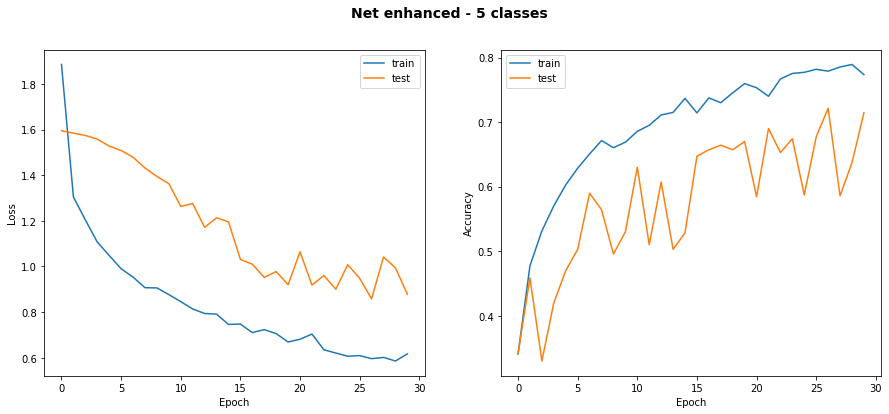

In [ ]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.suptitle("Net enhanced - 5 classes", fontsize=14, fontweight='bold')

In [ ]:
#net.save('best_5.h5')
#net = None
net_2 = keras.models.load_model('best_5.h5')

In [ ]:
class_probs = net_2.predict(test_images)

top1 = 0.0

for i, l in enumerate(test_images.labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:3]
    if top_values[0] == l:
        top1 += 1.0

print("top1 acc", top1/len(test_images.labels))

24/24 [==============================] - 9s 357ms/step
top1 acc 0.6873333333333334


In [ ]:
#classification report

predictions = np.argmax(class_probs, axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

     lasagna       0.90      0.47      0.62       300
     oysters       0.68      0.84      0.75       300
      paella       0.68      0.79      0.73       300
     risotto       0.72      0.53      0.61       300
       sushi       0.60      0.81      0.69       300

    accuracy                           0.69      1500
   macro avg       0.72      0.69      0.68      1500
weighted avg       0.72      0.69      0.68      1500



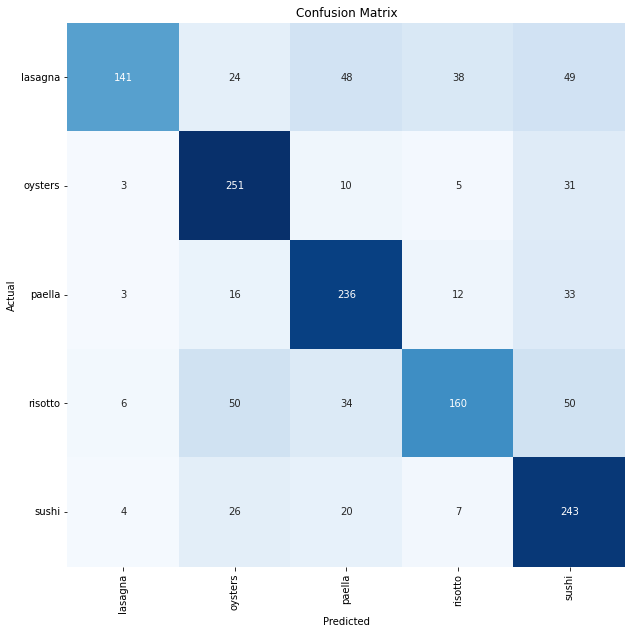

In [ ]:
#confusion matrix

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(5) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(5) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Gamma correction

In [ ]:
def image_agcwd(img, a=0.25):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    inverse_cdf = 1 - cdf_prob_normalized_wd
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
#     print ("%f %f"%(prob_min, prob_max))
    plt.plot(inverse_cdf, color = 'b')
#     plt.plot(inverse_cdf, color = 'r')
#     plt.ylim([0,0.15])
    plt.show()
    
    return img_new

In [ ]:
def image_agcwd_truncated(img, a=0.75):
    h,w = img.shape[:2]
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()
    prob_normalized = hist / hist.sum()

    unique_intensity = np.unique(img)
    intensity_max = unique_intensity.max()
    intensity_min = unique_intensity.min()
    prob_min = prob_normalized.min()
    prob_max = prob_normalized.max()
    
    pn_temp = (prob_normalized - prob_min) / (prob_max - prob_min)
    pn_temp[pn_temp>0] = prob_max * (pn_temp[pn_temp>0]**a)
    pn_temp[pn_temp<0] = prob_max * (-((-pn_temp[pn_temp<0])**a))
    prob_normalized_wd = pn_temp / pn_temp.sum() # normalize to [0,1]
    cdf_prob_normalized_wd = prob_normalized_wd.cumsum()
    inverse_cdf = np.maximum(0.5,1 - cdf_prob_normalized_wd)
    
    img_new = img.copy()
    for i in unique_intensity:
        img_new[img==i] = np.round(255 * (i / 255)**inverse_cdf[i])
   
#     print ("%f %f"%(prob_min, prob_max))
#     print (cdf_prob_normalized_wd.min(),cdf_prob_normalized_wd.max())
#     print(hist.sum(),h*w)
    plt.plot(prob_normalized_wd, color = 'b')
#     plt.plot(inverse_cdf, color = 'r')
    plt.ylim([0,0.2])
    plt.show()
    
    return img_new

In [ ]:
def process_bright(img):
    img_negative = 255 - img
#     plt.imshow(img_negative, cmap='gray')
#     plt.title('Negative Image')
#     plt.show()
    
    agcwd = image_agcwd(img_negative)
    reversed = 255 - agcwd
    return reversed

In [ ]:
def process_dimmed(img):
    agcwd = image_agcwd_truncated(img)
    return agcwd

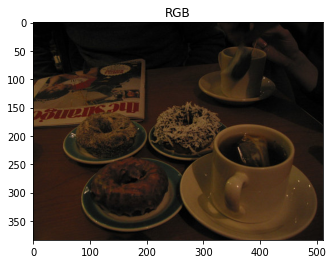

In [ ]:
# Read image
img = cv2.imread('/content/food-50/donuts/878.jpg',)
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
Y = YCrCb[:,:,0]
plt.imshow(rgb)
plt.title('RGB')
plt.show()

Dimmed Image


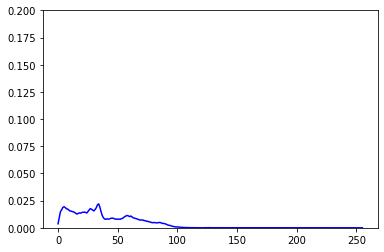

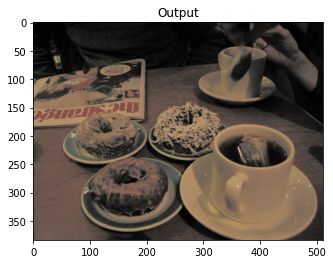

In [ ]:
# Determine whether image is bright or dimmed
threshold = 0.3
T_t = 112 # Global average brightness 
M,N = img.shape[:2]
m_I = np.sum(Y/(M*N)) 
t = (m_I - T_t)/ T_t

img_output = None
if t < -threshold:
    print ("Dimmed Image")
    result = process_dimmed(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2RGB)
    plt.imshow(img_output)
    plt.title('Output')
    plt.show()
elif t > threshold:
    print ("Bright Image")
    result = process_bright(Y)
    YCrCb[:,:,0] = result
    img_output = cv2.cvtColor(YCrCb,cv2.COLOR_YCrCb2RGB)
    plt.imshow(img_output)
    plt.title('Output')
    plt.show()

## **50 classes**

### Transfer learning with ResNet50

important shuffle false test

In [ ]:
train_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 28000 validated image filenames belonging to 50 classes.
Found 7000 validated image filenames belonging to 50 classes.
Found 15000 validated image filenames belonging to 50 classes.


In [ ]:
num_classes = 50
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

In [ ]:
# load pre-trained InceptionV3
base_net = ResNet50(weights='imagenet', include_top=False,
                          input_shape=img_shape, pooling='avg')


#freeze
for layer in base_net.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
inputs = base_net.input

x = Dense(128, activation='relu')(base_net.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Specialized model
net = keras.Model(inputs=inputs, outputs=outputs)

net.compile(optimizer = Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3)])

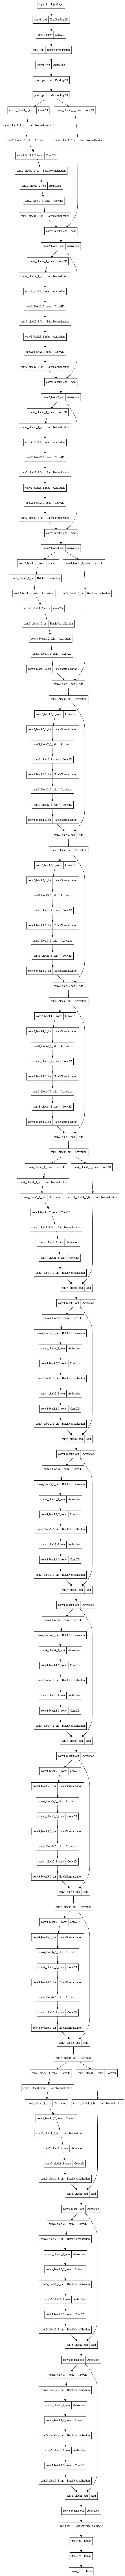

In [ ]:
# Visualization in graphical form
keras.utils.plot_model(net, to_file='model.png')

In [ ]:
# Model training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = net.fit(train_images,
          epochs=30,
          validation_data=val_images, 
          callbacks = [callback],
          verbose = 1);


net.save('new_resnet_50class.h5')

Epoch 1/30
438/438 [==============================] - 187s 421ms/step - loss: 3.8902 - accuracy: 0.0272 - top_k_categorical_accuracy: 0.0820 - val_loss: 3.8578 - val_accuracy: 0.0380 - val_top_k_categorical_accuracy: 0.0934
Epoch 2/30
438/438 [==============================] - 182s 416ms/step - loss: 3.8437 - accuracy: 0.0386 - top_k_categorical_accuracy: 0.1011 - val_loss: 3.8198 - val_accuracy: 0.0426 - val_top_k_categorical_accuracy: 0.1084
Epoch 3/30
438/438 [==============================] - 182s 415ms/step - loss: 3.7947 - accuracy: 0.0474 - top_k_categorical_accuracy: 0.1255 - val_loss: 3.7829 - val_accuracy: 0.0473 - val_top_k_categorical_accuracy: 0.1193
Epoch 4/30
438/438 [==============================] - 180s 410ms/step - loss: 3.7383 - accuracy: 0.0578 - top_k_categorical_accuracy: 0.1494 - val_loss: 3.7015 - val_accuracy: 0.0623 - val_top_k_categorical_accuracy: 0.1584
Epoch 5/30
438/438 [==============================] - 181s 412ms/step - loss: 3.6973 - accuracy: 0.0649 

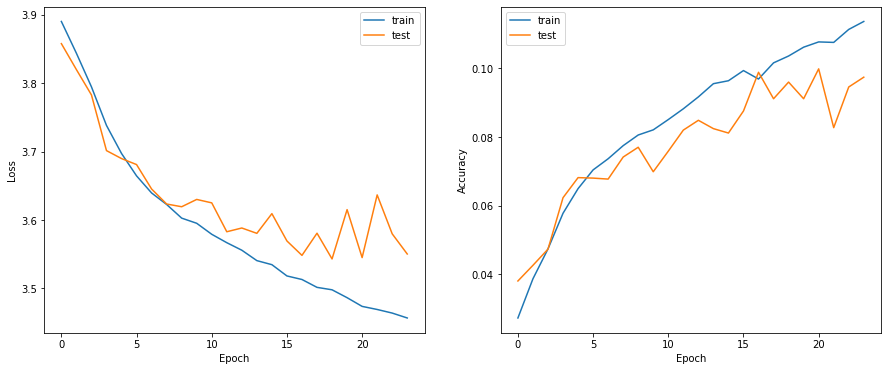

In [ ]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

raggiunto
- top1 acc 0.09053333333333333
- top3 acc 0.21186666666666668

### Transfer Learning with InceptionV3

In [ ]:
# load pre-trained InceptionV3
base_net = InceptionV3(weights='imagenet', include_top=False,
                          input_shape=img_shape, pooling='avg')


#freeze
for layer in base_net.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


#### preprocessing input

In [ ]:
# Explicit input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
# Image preprocessing for consistency with the pretrained model
x = keras.applications.inception_v3.preprocess_input(x)
# Output of the base model
x = base_net(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

net = keras.Model(inputs = inputs, outputs = outputs)

net.compile(optimizer = Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3)])

In [ ]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

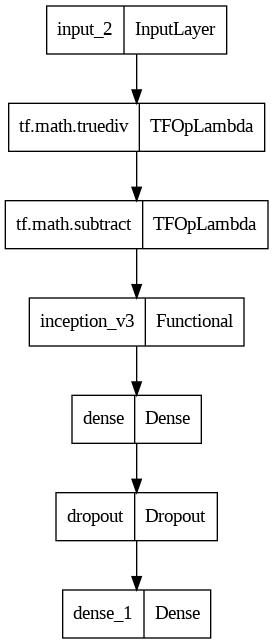

In [ ]:
# Show a high-level architecture
keras.utils.plot_model(net)

In [ ]:
# Model training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = net.fit(train_images,
          epochs=30,
          validation_data=val_images, 
          callbacks = [callback],
          verbose = 1);


net.save('inception_50class.h5')

Epoch 1/30
438/438 [==============================] - 196s 420ms/step - loss: 3.7876 - accuracy: 0.0557 - top_k_categorical_accuracy: 0.1360 - val_loss: 3.6757 - val_accuracy: 0.0709 - val_top_k_categorical_accuracy: 0.1767
Epoch 2/30
438/438 [==============================] - 162s 369ms/step - loss: 3.6330 - accuracy: 0.0800 - top_k_categorical_accuracy: 0.1914 - val_loss: 3.6188 - val_accuracy: 0.0840 - val_top_k_categorical_accuracy: 0.1964
Epoch 3/30
438/438 [==============================] - 159s 364ms/step - loss: 3.5697 - accuracy: 0.0934 - top_k_categorical_accuracy: 0.2122 - val_loss: 3.5820 - val_accuracy: 0.0934 - val_top_k_categorical_accuracy: 0.2143
Epoch 4/30
438/438 [==============================] - 157s 359ms/step - loss: 3.5258 - accuracy: 0.1010 - top_k_categorical_accuracy: 0.2285 - val_loss: 3.5386 - val_accuracy: 0.1034 - val_top_k_categorical_accuracy: 0.2287
Epoch 5/30
438/438 [==============================] - 158s 361ms/step - loss: 3.4892 - accuracy: 0.1103 

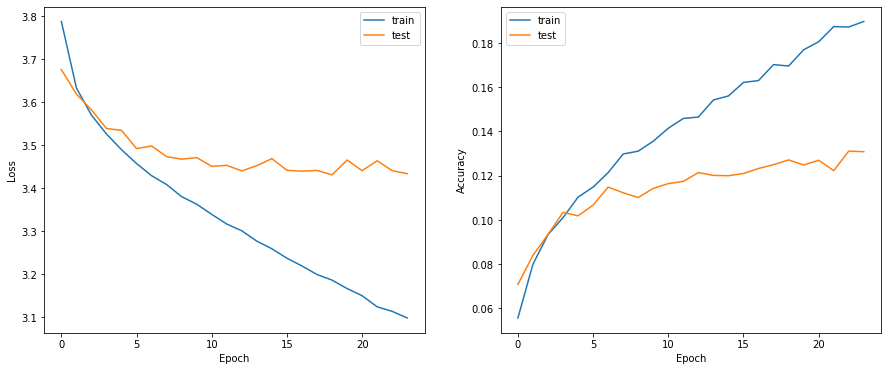

In [ ]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
net = None
net50_1 = keras.models.load_model('inception_50class.h5')

In [ ]:
y_test = test_images.labels

top1 = 0.0
top3 = 0.0    
class_probs = inception_50class.predict(test_images)

for i, l in enumerate(test_images.labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:3]
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top3 += 1.0

print("top1 acc", top1/len(test_images.labels))
print("top3 acc", top3/len(test_images.labels))

235/235 [==============================] - 85s 359ms/step
top1 acc 0.19206666666666666
top3 acc 0.3662


**inceptionv3** with 50 classes:
  - top1 accuracy 19%
  - top3 accuracy 36%

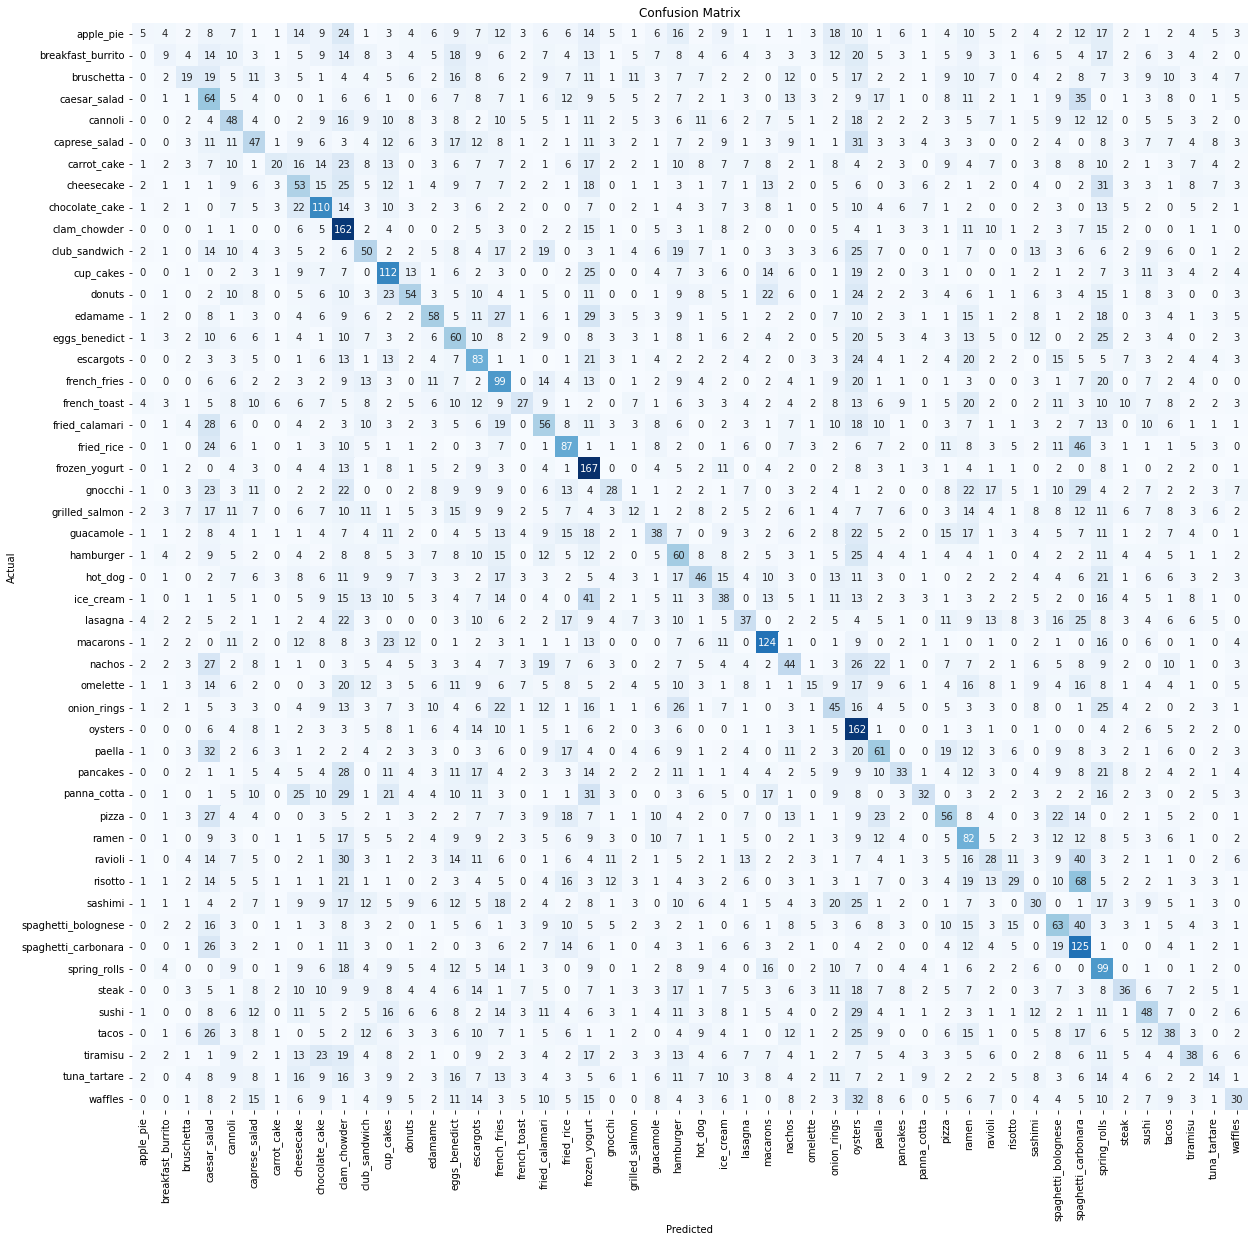

In [ ]:
predictions = np.argmax(class_probs, axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)


plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(50) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(50) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

ex : ice cream and frozen yogurt similar!!

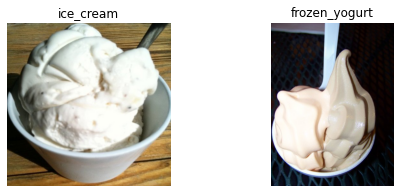

In [ ]:
img1 = io.imread('/content/food-50/ice_cream/281269.jpg')
img2 = io.imread('/content/food-50/frozen_yogurt/11003.jpg')

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].axis('off'); axs[0].imshow(img1); axs[0].set_title('ice_cream');
axs[1].axis('off'); axs[1].imshow(img2); axs[1].set_title('frozen_yogurt');

# Mostra il plot
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                      precision    recall  f1-score   support

          apple_pie       0.12      0.02      0.03       300
  breakfast_burrito       0.14      0.03      0.05       300
         bruschetta       0.18      0.06      0.09       300
       caesar_salad       0.12      0.21      0.15       300
            cannoli       0.15      0.16      0.16       300
      caprese_salad       0.17      0.16      0.16       300
        carrot_cake       0.28      0.07      0.11       300
         cheesecake       0.16      0.18      0.17       300
     chocolate_cake       0.28      0.37      0.32       300
       clam_chowder       0.21      0.54      0.30       300
      club_sandwich       0.16      0.17      0.17       300
          cup_cakes       0.25      0.37      0.30       300
             donuts       0.24      0.18      0.21       300
            edamame       0.24      0.19      0.21       300
      eggs_benedict       0.15      0

#### without preprocess

in inception

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = base_net(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Specialized model
net = keras.Model(inputs=inputs, outputs=outputs)

net.compile(optimizer = Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3)])

In [ ]:
net.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 50)                51250     
                                                                 
Total params: 23,952,210
Trainable params: 2,149,426
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Model training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = net.fit(train_images,
          epochs=30,
          validation_data=val_images, 
          callbacks = [callback],
          verbose = 1);


net.save('new_inception_50.h5')

Epoch 1/30
438/438 [==============================] - 217s 485ms/step - loss: 1.9916 - accuracy: 0.4703 - top_k_categorical_accuracy: 0.6739 - val_loss: 1.5799 - val_accuracy: 0.5674 - val_top_k_categorical_accuracy: 0.7664
Epoch 2/30
438/438 [==============================] - 219s 501ms/step - loss: 1.5540 - accuracy: 0.5719 - top_k_categorical_accuracy: 0.7695 - val_loss: 1.5001 - val_accuracy: 0.5831 - val_top_k_categorical_accuracy: 0.7800
Epoch 3/30
438/438 [==============================] - 218s 498ms/step - loss: 1.4018 - accuracy: 0.6058 - top_k_categorical_accuracy: 0.8012 - val_loss: 1.4596 - val_accuracy: 0.5964 - val_top_k_categorical_accuracy: 0.7906
Epoch 4/30
438/438 [==============================] - 198s 453ms/step - loss: 1.3109 - accuracy: 0.6289 - top_k_categorical_accuracy: 0.8176 - val_loss: 1.4596 - val_accuracy: 0.5993 - val_top_k_categorical_accuracy: 0.7931
Epoch 5/30
438/438 [==============================] - 194s 443ms/step - loss: 1.2189 - accuracy: 0.6541 

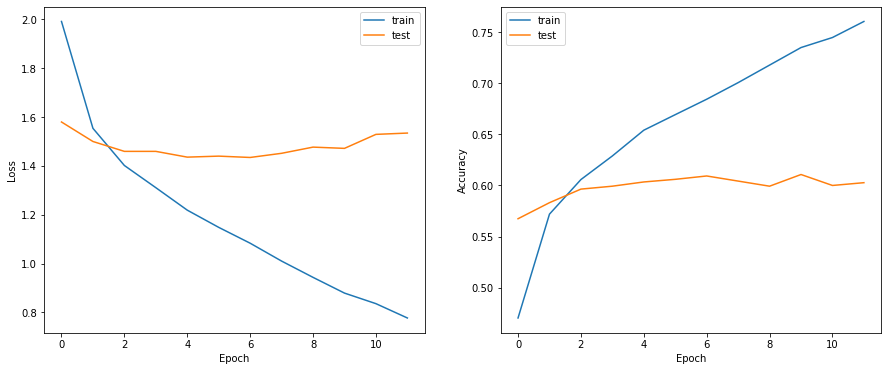

In [ ]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
net = None
net50_2 = keras.models.load_model('new_inception_50.h5')

In [ ]:
y_test = test_images.labels

top1 = 0.0
top3 = 0.0    
class_probs = net50_2.predict(test_images)

for i, l in enumerate(test_images.labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:3]
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top3 += 1.0

print("top1 acc", top1/len(test_images.labels))
print("top3 acc", top3/len(test_images.labels))

235/235 [==============================] - 95s 398ms/step
top1 acc 0.5999333333333333
top3 acc 0.7872666666666667


**inceptionv3** with 50 classes **without preprocessing**:
  - top1 accuracy 60%
  - top3 accuracy 79%

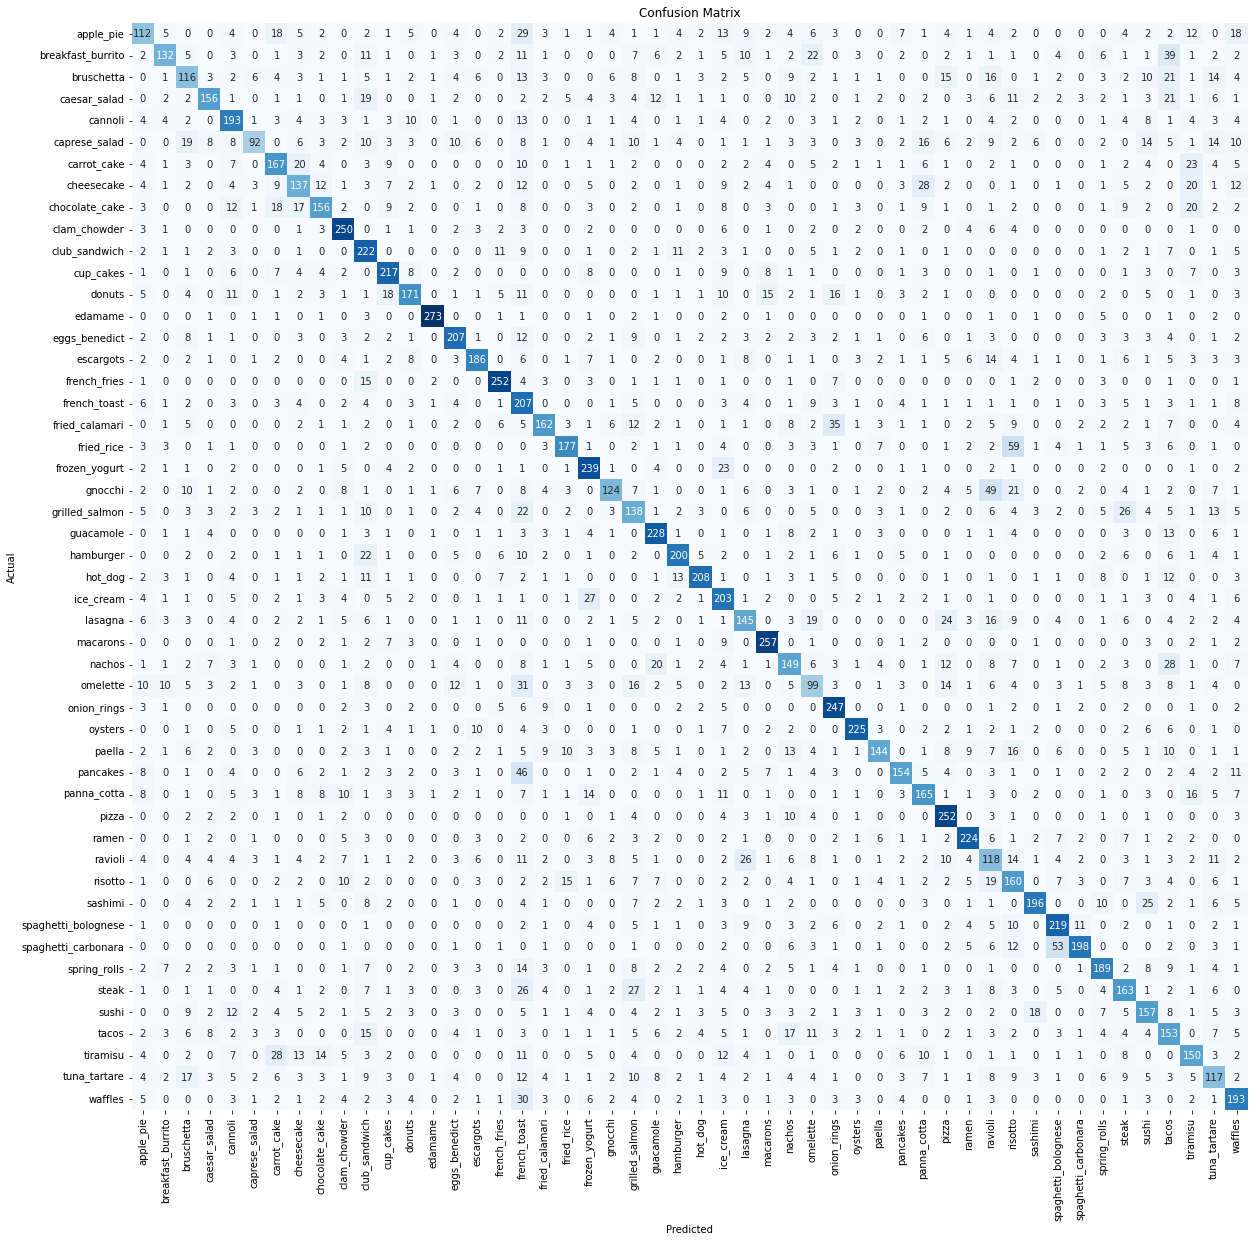

In [ ]:
predictions = np.argmax(class_probs, axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(50) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(50) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

--> es effettivamente simili fried rice / risotto 59
--> es gnocchi / ravioli 49
--> es pancakes / french toast 46

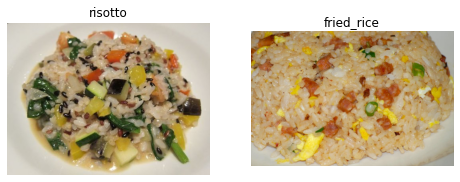

In [ ]:
img1 = io.imread('/content/food-50/risotto/40801.jpg')
img2 = io.imread('/content/food-50/fried_rice/1084.jpg')

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].axis('off'); axs[0].imshow(img1); axs[0].set_title('risotto');
axs[1].axis('off'); axs[1].imshow(img2); axs[1].set_title('fried_rice');

# Mostra il plot
plt.show()

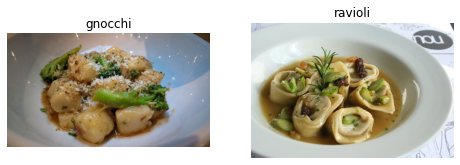

In [ ]:
img1 = io.imread('/content/food-50/gnocchi/7508.jpg')
img2 = io.imread('/content/food-50/ravioli/137407.jpg')

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].axis('off'); axs[0].imshow(img1); axs[0].set_title('gnocchi');
axs[1].axis('off'); axs[1].imshow(img2); axs[1].set_title('ravioli');

# Mostra il plot
plt.show()

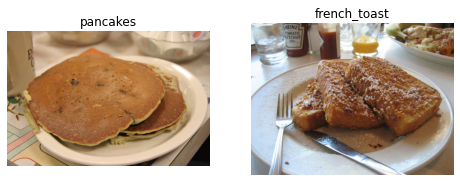

In [ ]:
img1 = io.imread('/content/food-50/pancakes/53205.jpg')
img2 = io.imread('/content/food-50/french_toast/6264.jpg')

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].axis('off'); axs[0].imshow(img1); axs[0].set_title('pancakes');
axs[1].axis('off'); axs[1].imshow(img2); axs[1].set_title('french_toast');

# Mostra il plot
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                      precision    recall  f1-score   support

          apple_pie       0.48      0.37      0.42       300
  breakfast_burrito       0.71      0.44      0.54       300
         bruschetta       0.45      0.39      0.42       300
       caesar_salad       0.69      0.52      0.59       300
            cannoli       0.57      0.64      0.60       300
      caprese_salad       0.71      0.31      0.43       300
        carrot_cake       0.56      0.56      0.56       300
         cheesecake       0.51      0.46      0.48       300
     chocolate_cake       0.63      0.52      0.57       300
       clam_chowder       0.70      0.83      0.76       300
      club_sandwich       0.50      0.74      0.60       300
          cup_cakes       0.68      0.72      0.70       300
             donuts       0.69      0.57      0.62       300
            edamame       0.95      0.91      0.93       300
      eggs_benedict       0.68      0

### Add augmentation on the best net

In [ ]:
# load pre-trained InceptionV3
base_net = InceptionV3(weights='imagenet', include_top=False,
                          input_shape=img_shape, pooling='avg')


#freeze
for layer in base_net.layers:
    layer.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

#augmentation
x = keras.layers.RandomFlip()(x) #horizontal_and_vertical
x = keras.layers.RandomContrast(0.25)(x)

x = base_net(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Specialized model
net = keras.Model(inputs=inputs, outputs=outputs)

net.compile(optimizer = Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3)])

In [ ]:
net.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                           

In [ ]:
# Model training
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = net.fit(train_images,
          epochs=10,
          validation_data=val_images, 
          callbacks = [callback],
          verbose = 1);


net.save('new2_inception_50.h5')

Epoch 1/10


438/438 [==============================] - 399s 895ms/step - loss: 2.1751 - accuracy: 0.4288 - top_k_categorical_accuracy: 0.6323 - val_loss: 1.6972 - val_accuracy: 0.5304 - val_top_k_categorical_accuracy: 0.7439
Epoch 2/10
438/438 [==============================] - 389s 888ms/step - loss: 1.7658 - accuracy: 0.5170 - top_k_categorical_accuracy: 0.7244 - val_loss: 1.5735 - val_accuracy: 0.5667 - val_top_k_categorical_accuracy: 0.7721
Epoch 3/10
438/438 [==============================] - 382s 872ms/step - loss: 1.6494 - accuracy: 0.5443 - top_k_categorical_accuracy: 0.7500 - val_loss: 1.5506 - val_accuracy: 0.5707 - val_top_k_categorical_accuracy: 0.7716
Epoch 4/10
438/438 [==============================] - 379s 864ms/step - loss: 1.5895 - accuracy: 0.5610 - top_k_categorical_accuracy: 0.7619 - val_loss: 1.5373 - val_accuracy: 0.5780 - val_top_k_categorical_accuracy: 0.7776
Epoch 5/10
438/438 [==============================] - 382s 873ms/step - loss: 1.5314 - accuracy: 0.5741 - top_k_cat

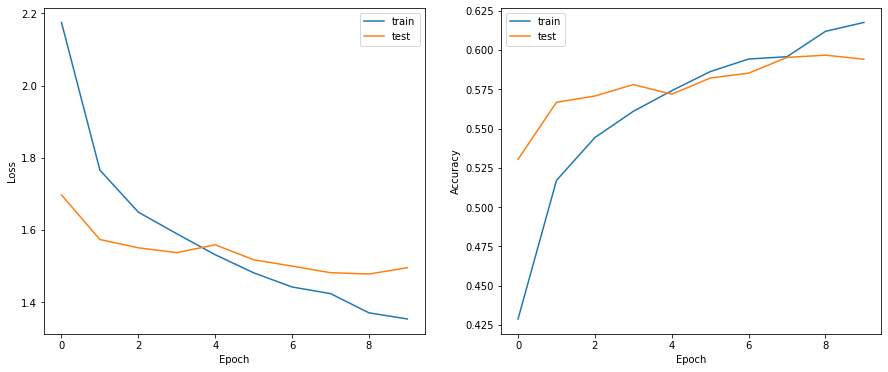

In [ ]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
net = None
net50_2 = keras.models.load_model('new2_inception_50.h5')

In [ ]:
y_test = test_images.labels

top1 = 0.0
top3 = 0.0    
class_probs = net50_2.predict(test_images)

for i, l in enumerate(test_images.labels):
    class_prob = class_probs[i]
    top_values = (-class_prob).argsort()[:3]
    if top_values[0] == l:
        top1 += 1.0
    if np.isin(np.array([l]), top_values):
        top3 += 1.0

print("top1 acc", top1/len(test_images.labels))
print("top3 acc", top3/len(test_images.labels))

235/235 [==============================] - 101s 427ms/step
top1 acc 0.6005333333333334
top3 acc 0.789


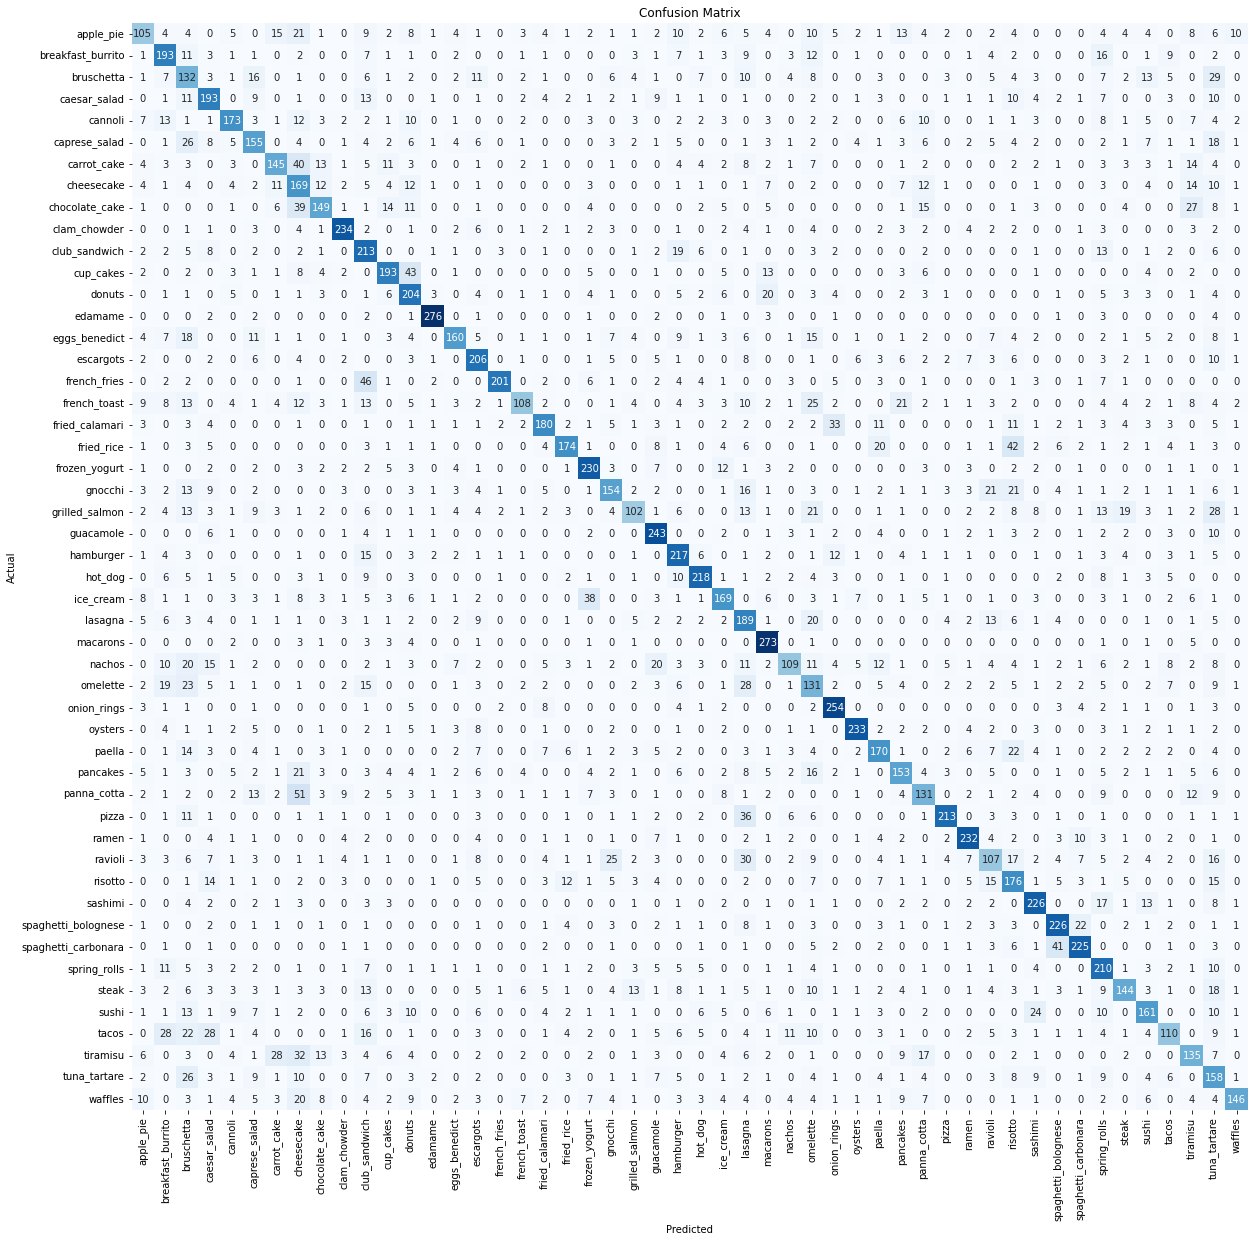

In [ ]:
predictions = np.argmax(class_probs, axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(50) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(50) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

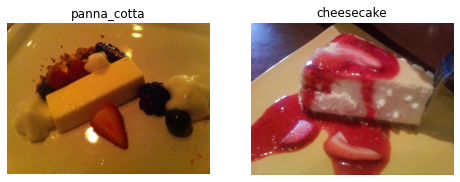

In [ ]:
# panna cotta e cheesecake --> 51
img1 = io.imread('/content/food-50/panna_cotta/182132.jpg')
img2 = io.imread('/content/food-50/cheesecake/23673.jpg')

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].axis('off'); axs[0].imshow(img1); axs[0].set_title('panna_cotta');
axs[1].axis('off'); axs[1].imshow(img2); axs[1].set_title('cheesecake');

# Mostra il plot
plt.show()

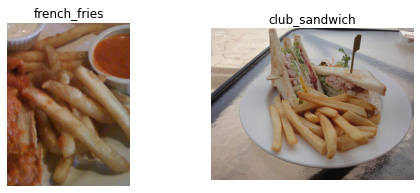

In [ ]:
# french fries e club sandwich --> 46

img1 = io.imread('/content/food-50/french_fries/51368.jpg')
img2 = io.imread('/content/food-50/club_sandwich/41847.jpg')

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].axis('off'); axs[0].imshow(img1); axs[0].set_title('french_fries');
axs[1].axis('off'); axs[1].imshow(img2); axs[1].set_title('club_sandwich');

# Mostra il plot
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                      precision    recall  f1-score   support

          apple_pie       0.51      0.35      0.42       300
  breakfast_burrito       0.55      0.64      0.59       300
         bruschetta       0.30      0.44      0.36       300
       caesar_salad       0.55      0.64      0.59       300
            cannoli       0.68      0.58      0.62       300
      caprese_salad       0.52      0.52      0.52       300
        carrot_cake       0.63      0.48      0.55       300
         cheesecake       0.34      0.56      0.43       300
     chocolate_cake       0.63      0.50      0.56       300
       clam_chowder       0.82      0.78      0.80       300
      club_sandwich       0.46      0.71      0.55       300
          cup_cakes       0.69      0.64      0.67       300
             donuts       0.52      0.68      0.59       300
            edamame       0.91      0.92      0.92       300
      eggs_benedict       0.74      0

### DEMO

In [ ]:
test_df

Filepath           Label
29812         /content/food-50/pancakes/842552.jpg        pancakes
7401   /content/food-50/fried_calamari/2824864.jpg  fried_calamari
26147    /content/food-50/french_fries/3871541.jpg    french_fries
28846          /content/food-50/gnocchi/937655.jpg         gnocchi
46803          /content/food-50/risotto/172623.jpg         risotto
...                                            ...             ...
37247        /content/food-50/escargots/554207.jpg       escargots
15922        /content/food-50/macarons/3690915.jpg        macarons
2991    /content/food-50/club_sandwich/1058213.jpg   club_sandwich
49437    /content/food-50/frozen_yogurt/246214.jpg   frozen_yogurt
1168             /content/food-50/pizza/929067.jpg           pizza

[15000 rows x 2 columns]

In [ ]:
net = None
net50_2 = keras.models.load_model('/content/gdrive/MyDrive/DSIM_project/new2_inception_50.h5')

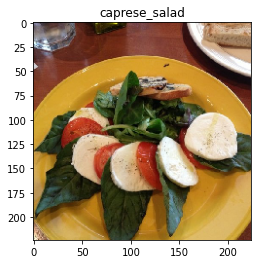

In [ ]:
i = 11258
img = kimage.load_img(test_df.Filepath.iloc[i], target_size=(224, 224))

plt.imshow(img)
plt.title(test_df.Label.iloc[i])
plt.show()

In [ ]:
labels = list(set(train_df.Label))

In [ ]:
def demo(i):
  img = kimage.load_img(test_df.Filepath.iloc[i], target_size=(224, 224))
  plt.imshow(img)
  plt.title(test_df.Label.iloc[i])  
  plt.show()

  x = kimage.img_to_array(img)
  x = x.astype('float32')
  x /=255.0
  x = np.expand_dims(x, axis=0)
  yc_pred = net50_2.predict(x)
    
  m, n = yc_pred.shape
  file_names = labels
  indices = np.argpartition(-yc_pred, 3, axis=1)[:, :3]
  probs = np.sort(-yc_pred, axis=1)[:, :3]
  df = pd.DataFrame({'Index': indices.flatten(), 'Probability': -probs.flatten()})
  df['File Name'] = [file_names[index] for index in indices.flatten()]
  df.columns = ['Index', 'Probability', 'Label']
  return df

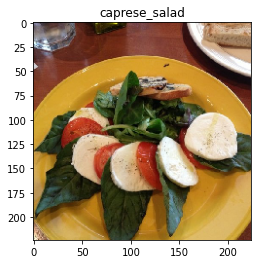

1/1 [==============================] - 9s 9s/step


Index  Probability          Label
0      5     0.883761   french_fries
1     45     0.043919  eggs_benedict
2     40     0.024181       pancakes

In [ ]:
demo(11258)

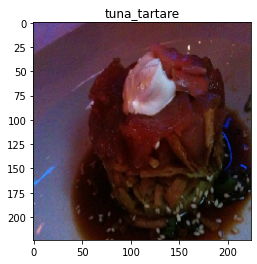

1/1 [==============================] - 0s 48ms/step


Index  Probability         Label
0     34     0.302176       hot_dog
1      0     0.263425       cannoli
2     24     0.157048  tuna_tartare

In [ ]:
i = random.randint(0,15000)
demo(i)

# **RETRIEVAL**

Import the pretrained model

In [6]:
#net = keras.applications.InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top = False, pooling = 'max')
#net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max') #without last layer for classifiction
net = keras.applications.ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

94765736/94765736 [==============================] - 1s 0us/step


Data loader

In [ ]:
# train_sub, test_sub = train_test_split(images, train_size=0.9, shuffle=True, random_state=1, stratify= images['Label'])
# train_sub.to_csv('/content/gdrive/MyDrive/Second year/DSIM_project/train_sub.csv')
# test_sub.to_csv('/content/gdrive/MyDrive/Second year/DSIM_project/test_sub.csv')

In [7]:
train_sub = pd.read_csv('/content/gdrive/MyDrive/Second year/DSIM_project/train_sub.csv')
test_sub = pd.read_csv('/content/gdrive/MyDrive/Second year/DSIM_project/test_sub.csv')

# train_sub = pd.read_csv('/content/gdrive/MyDrive/DSIM_project/train_sub.csv')
# test_sub = pd.read_csv('/content/gdrive/MyDrive/DSIM_project/test_sub.csv')

In [ ]:
print(len(train_sub))
print(len(test_sub))

45000
5000


In [8]:
# Dummy feature
def identity(image):
    return kimage.img_to_array(img).flatten()

# Data loader: identity importa img e la srotola in vett
def load_data(feature_extractor=identity):
    features = []
    paths = []
       
    for elem in list(train_sub.Filepath):
      paths.append(elem)
      image = kimage.load_img(elem, target_size=(224, 224))
      cur_features = feature_extractor(image)
      features.append(cur_features)

    features = np.array(features)
    
    return features, paths

Feature extraction

In [9]:
def neural_features(img):
  x = kimage.img_to_array(img)
  x = keras.applications.resnet50.preprocess_input(x)
  x = np.expand_dims(x, axis=0)
  f = net.predict(x, verbose=False)   #per non printare riga esecuzione
  return f.flatten()    #flatten per eliminare le dim extra
  

In [ ]:
# t0 = time()
# X_train, paths = load_data(feature_extractor=neural_features)
# print("Data loading and feature extraction completed in %0.3f seconds." % (time() - t0))

Data loading and feature extraction completed in 2925.475 seconds.


In [ ]:
# def save_data(X_train, paths, filename):
#     with open(filename, 'wb') as f:
#         pickle.dump((X_train, paths), f)

# save_data(X_train, paths, '/content/gdrive/MyDrive/Second year/DSIM_project/saved_data.pkl')


Search tree : KD-Tree

In [ ]:
# tree = KDTree(X_train)

In [ ]:
# #Saving the search tree
#joblib.dump(tree, '/content/gdrive/MyDrive/Second year/DSIM_project/food_kdtree.joblib')

['/content/gdrive/MyDrive/Second year/DSIM_project/food_kdtree.joblib']

### Querying the search tree

In [10]:
# Loading out train set: 45000 images
def load_saved_data(filename):
    with open(filename, 'rb') as f:
        X_train, paths = pickle.load(f)
    return X_train, paths

X_train, paths = load_saved_data('/content/gdrive/MyDrive/Second year/DSIM_project/MODELLI_RETRIEVAL/saved_data.pkl')


In [11]:
X_train.shape

(45000, 2048)

In [12]:
# Loading the search tree
tree = None
tree = joblib.load('/content/gdrive/MyDrive/Second year/DSIM_project/MODELLI_RETRIEVAL/food_kdtree.joblib')

In [13]:
# First 10 most similar images

def plot_10(image):
  plt.figure(figsize=(25,10))
  for i in range(10):
    plt.subplot(1, 10, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    image = io.imread(paths[ind[0][i]])
    title = paths[ind[0][i]].split('/')[-2]
    plt.title(f'{i+1}: {title}', fontsize= 10)
    plt.imshow(image)
  return plt.show()

#### Metrics for evaluation

In [14]:
def abs_frequency(query_label):

  label = query_label
  j=0
  for i in range(100):
    title = paths[ind[0][i]].split('/')[-2]
    if title == label:
      j+=1

  return j/100


In [15]:
def top10_frequency(query_label):

  label = query_label
  j=0
  for i in range(10):
    title = paths[ind[0][i]].split('/')[-2]
    if title == label:
      j+=1

  return j/10

In [16]:
def tot_frequency(query_label):

  label = query_label
  j=0
  for i in range(900):
    title = paths[ind[0][i]].split('/')[-2]
    if title == label:
      j+=1

  return j/900

In [17]:
def bool_freq(query_label):

  label = query_label
  title = paths[ind[0][0]].split('/')[-2]
  if title == label:
    return 1
  else:
    return 0

### DEMO 1

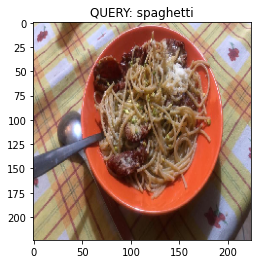

In [24]:
query_image = kimage.load_img('/content/gdrive/MyDrive/Second year/DSIM_project/spaghetto.jpg', target_size=(224, 224))
query_label = 'QUERY: spaghetti'
plt.imshow(query_image)
plt.title(query_label)
plt.show()

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


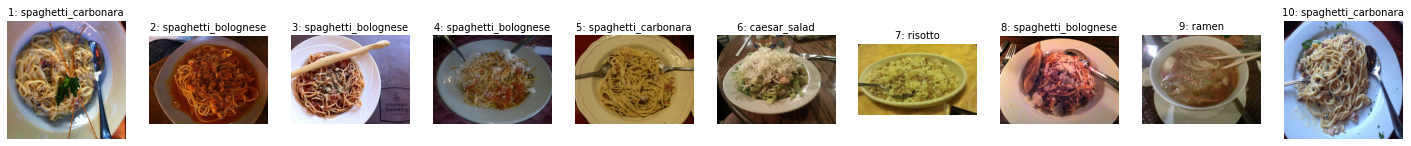

In [25]:
# Computing query features
query_features = neural_features(query_image)
# Adding one dimension as required by the KDTree
query_features = np.expand_dims(query_features, axis=0)
# Search, k = 100
dist, ind = tree.query(query_features, k=100)

plot_10(query_image)

### DEMO 2

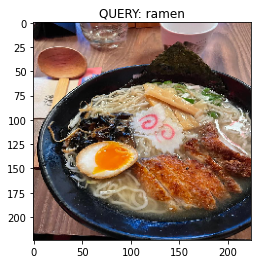

In [26]:
query_image = kimage.load_img('/content/gdrive/MyDrive/Second year/DSIM_project/ramen_milano.jpg', target_size=(224, 224))
query_label = 'QUERY: ramen'
plt.imshow(query_image)
plt.title(query_label)
plt.show()

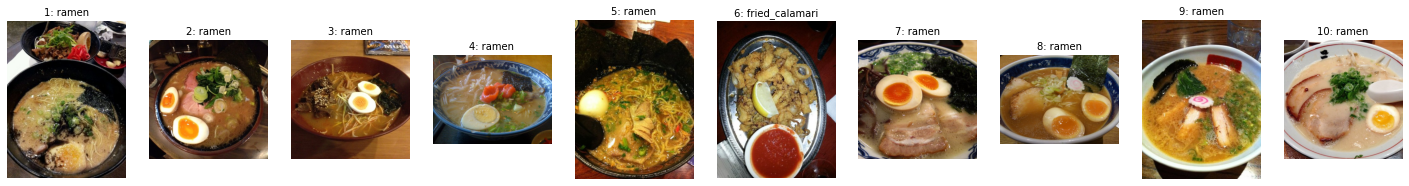

In [27]:
# Computing query features
query_features = neural_features(query_image)
# Adding one dimension as required by the KDTree
query_features = np.expand_dims(query_features, axis=0)
# Search, k = 100
dist, ind = tree.query(query_features, k=100)

plot_10(query_image)

#### TEST 1

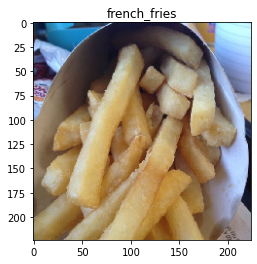

In [ ]:
query_image = kimage.load_img(test_sub.Filepath.iloc[100], target_size=(224, 224))
query_label = test_sub.Label.iloc[100]
plt.imshow(query_image)
plt.title(query_label)
plt.show()

In [ ]:
# Computing query features
query_features = neural_features(query_image)
# Adding one dimension as required by the KDTree
query_features = np.expand_dims(query_features, axis=0)
query_features.shape

(1, 2048)

search and return N most similar images.
We set N = 100 in order to compute absolute frequency (for each class there are exactly 100 images in the test set).

In [ ]:
# Search, k = 100
dist, ind = tree.query(query_features, k=100)

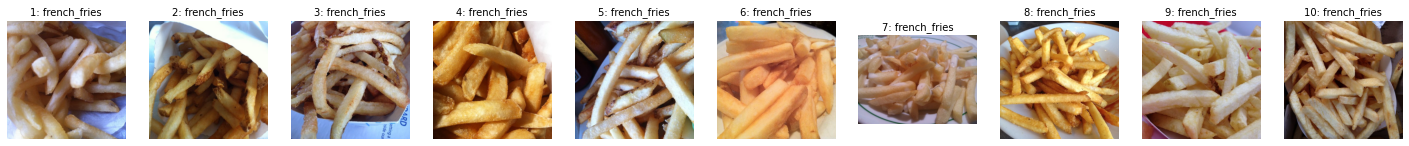

In [ ]:
plot_10(query_image)

Perfect search!

In [ ]:
top10_frequency(query_label)

1.0

85% of the total number of images matching the query images were found!

#### TEST 2

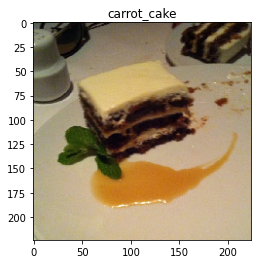

In [ ]:
query_image = kimage.load_img(test_sub.Filepath.iloc[316], target_size=(224, 224))
query_label = test_sub.Label.iloc[316]
plt.imshow(query_image)
plt.title(query_label)
plt.show()

In [ ]:
# Computing query features
query_features = neural_features(query_image)
# Adding one dimension as required by the KDTree
query_features = np.expand_dims(query_features, axis=0)
query_features.shape

(1, 2048)

In [ ]:
# Search, k = 100
dist, ind = tree.query(query_features, k=100)

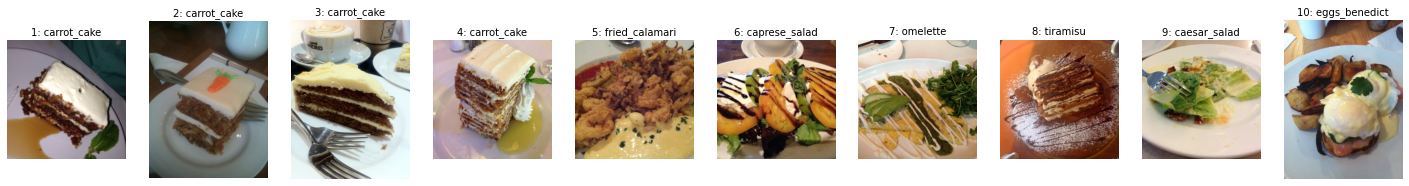

In [ ]:
plot_10(query_image)

In [ ]:
top10_frequency(query_label)

0.4

#### TEST 3

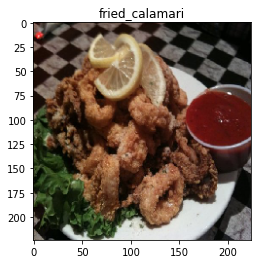

In [ ]:
query_image = kimage.load_img(test_sub.Filepath.iloc[219], target_size=(224, 224))
query_label = test_sub.Label.iloc[219]
plt.imshow(query_image)
plt.title(query_label)
plt.show()

In [ ]:
# Computing query features
query_features = neural_features(query_image)
# Adding one dimension as required by the KDTree
query_features = np.expand_dims(query_features, axis=0)
query_features.shape

(1, 2048)

In [ ]:
# Search, k = 100
dist, ind = tree.query(query_features, k=100)

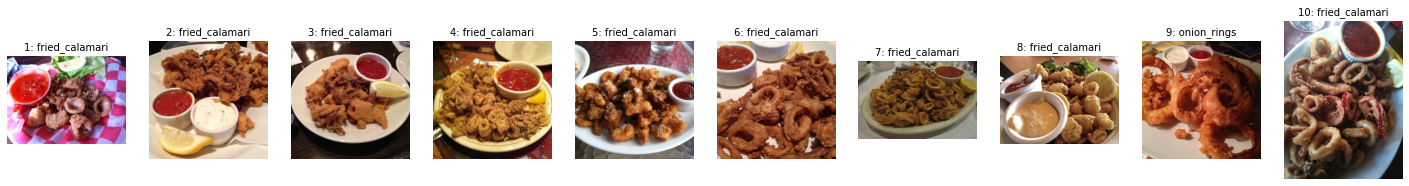

In [ ]:
plot_10(query_image)

In [ ]:
top10_frequency(query_label)

0.9

#### TEST 4

image from internet

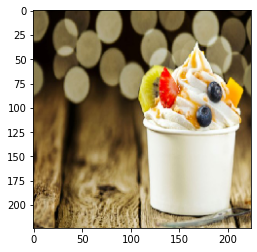

In [ ]:
query_image = kimage.load_img('/content/gdrive/MyDrive/Second year/DSIM_project/gelato.jpg', target_size=(224, 224))
query_label = 'frozen_yogurt'
plt.imshow(query_image)
plt.show()

In [ ]:
# Computing query features
query_features = neural_features(query_image)
# Adding one dimension as required by the KDTree
query_features = np.expand_dims(query_features, axis=0)
query_features.shape

(1, 2048)

In [ ]:
# Search, k = 100
dist, ind = tree.query(query_features, k=100)

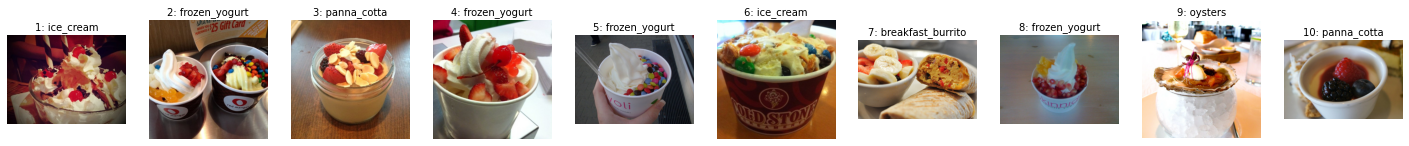

In [ ]:
plot_10(query_image)

In [ ]:
top10_frequency(query_label)

0.4

### Global Evalutaion

In [ ]:
len(test_sub)

5000

In [ ]:
labels = test_sub['Label'].unique().tolist()

In [ ]:
def global_freq(test_sub, label):
  
  df_label = test_sub[test_sub.Label == label]
  f1 = 0
  f2 = 0
  for i in range(100):
    query_image = kimage.load_img(df_label.Filepath.iloc[i], target_size=(224, 224))
    query_label = df_label.Label.iloc[i]
    # Computing query features
    query_features = neural_features(query_image)
    query_features = np.expand_dims(query_features, axis=0)
    # Search, k = 100
    dist, ind = tree.query(query_features, k=100)
    f1 += top10_frequency(query_label)
    f2 += abs_frequency(query_label)

  return(f1/100, f2/100)
    

In [ ]:
labels = test_sub['Label'].unique().tolist()

for label in labels:
  df_label = test_sub[test_sub.Label == label]
  f1 = 0
  f2 = 0
  for i in range(100):
    query_image = kimage.load_img(df_label.Filepath.iloc[i], target_size=(224, 224))
    query_label = df_label.Label.iloc[i]
    # Computing query features
    query_features = neural_features(query_image)
    query_features = np.expand_dims(query_features, axis=0)
    # Search, k = 100
    dist, ind = tree.query(query_features, k=100)
    f1 += top10_frequency(query_label)
    f2 += abs_frequency(query_label)
  print(label,':',f1/100,f2/100)

sushi : 0.21799999999999994 0.12569999999999998
ice_cream : 0.30499999999999994 0.15439999999999998
apple_pie : 0.18899999999999995 0.10819999999999994
guacamole : 0.5749999999999998 0.4104
fried_calamari : 0.31200000000000006 0.2104
spaghetti_carbonara : 0.7059999999999996 0.5809000000000002
lasagna : 0.38099999999999995 0.24470000000000003
grilled_salmon : 0.206 0.13379999999999997
spaghetti_bolognese : 0.5630000000000002 0.4180000000000002
oysters : 0.6459999999999998 0.4942999999999999
omelette : 0.15399999999999994 0.11299999999999999
french_fries : 0.7189999999999999 0.5648000000000001
nachos : 0.233 0.1586
spring_rolls : 0.326 0.18290000000000006
paella : 0.4050000000000001 0.2518000000000001
frozen_yogurt : 0.6130000000000002 0.4106000000000001
onion_rings : 0.6259999999999998 0.45409999999999984
carrot_cake : 0.31399999999999995 0.19269999999999993
chocolate_cake : 0.19500000000000003 0.12199999999999993
pizza : 0.5179999999999997 0.3674
waffles : 0.4109999999999999 0.24130000

mean(P(10)) = 0.41

In [ ]:
for label in labels[-2:]:
  f4 = 0
  df_label = test_sub[test_sub.Label == label]
  for i in range(100):
    query_image = kimage.load_img(df_label.Filepath.iloc[i], target_size=(224, 224))
    query_label = df_label.Label.iloc[i]
    # Computing query features
    query_features = neural_features(query_image)
    query_features = np.expand_dims(query_features, axis=0)
    # Search, k = 100
    dist, ind = tree.query(query_features, k=100)
    f4 += bool_freq(query_label)
  print(label,':',f4/100)

sashimi : 0.58
risotto : 0.31


In [ ]:
labels = test_sub['Label'].unique().tolist()

for label in labels:
  f4 = 0
  df_label = test_sub[test_sub.Label == label]
  for i in range(100):
    query_image = kimage.load_img(df_label.Filepath.iloc[i], target_size=(224, 224))
    query_label = df_label.Label.iloc[i]
    # Computing query features
    query_features = neural_features(query_image)
    query_features = np.expand_dims(query_features, axis=0)
    # Search, k = 100
    dist, ind = tree.query(query_features, k=100)
    f4 += bool_freq(query_label)
  print(label,':',f4/100)

sushi : 0.33
ice_cream : 0.41
apple_pie : 0.29
guacamole : 0.66
fried_calamari : 0.43
spaghetti_carbonara : 0.78
lasagna : 0.51
grilled_salmon : 0.26
spaghetti_bolognese : 0.63
oysters : 0.71
omelette : 0.23
french_fries : 0.8
nachos : 0.32
spring_rolls : 0.49
paella : 0.54
frozen_yogurt : 0.7
onion_rings : 0.73
carrot_cake : 0.36
chocolate_cake : 0.36
pizza : 0.55
waffles : 0.5
club_sandwich : 0.52
caesar_salad : 0.64
cannoli : 0.41
escargots : 0.66
hot_dog : 0.58
clam_chowder : 0.77
caprese_salad : 0.54
steak : 0.22
ravioli : 0.28
fried_rice : 0.58
bruschetta : 0.37
tiramisu : 0.28
tuna_tartare : 0.18
eggs_benedict : 0.59
tacos : 0.32
breakfast_burrito : 0.4
cheesecake : 0.29
gnocchi : 0.4
macarons : 0.83
panna_cotta : 0.48
french_toast : 0.42
ramen : 0.64
hamburger : 0.6
pancakes : 0.4
cup_cakes : 0.69
edamame : 0.95
donuts : 0.54


mean(P(1)) = 50.12